In [104]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import statsmodels.api as sm 

# Import the data

In [105]:
### Import the data

data = pd.read_csv('data/01_datawrangling_byzcta_out.csv', index_col=0)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
med_houseinc_12mon,30351.0,73288.381108,31254.278258,2499.0,53577.0,67056.000000,85313.000000,250001.000000
household_public_assistance1,30351.0,4107.685085,5670.465205,3.0,369.0,1304.000000,5895.500000,41653.000000
state_fips,30351.0,19.098316,18.728293,0.0,0.0,17.000000,36.000000,56.000000
nflood_total,30351.0,3.212448,6.145303,0.0,0.0,1.000000,4.000000,175.000000
flood_count_fall,30351.0,0.358143,1.082084,0.0,0.0,0.000000,0.000000,29.000000
flood_count_winter,30351.0,0.520246,1.685829,0.0,0.0,0.000000,0.000000,59.000000
flood_count_spring,30351.0,1.187934,2.669716,0.0,0.0,0.000000,1.000000,55.000000
nflood_2000s,30351.0,0.753089,1.837820,0.0,0.0,0.000000,1.000000,47.000000
nflood_2010s,30351.0,2.050114,4.243156,0.0,0.0,1.000000,2.000000,136.000000
flood_dur_hours_median,30351.0,10.507288,50.549679,0.0,0.0,1.475410,3.442623,731.786885


In [106]:
print(data.shape)
data.dtypes

(30351, 15)


med_houseinc_12mon                        float64
household_public_assistance1              float64
state_fips                                  int64
nflood_total                                int64
flood_count_fall                            int64
flood_count_winter                          int64
flood_count_spring                          int64
nflood_2000s                              float64
nflood_2010s                              float64
flood_dur_hours_median                    float64
flood_dur_hours_min                       float64
flood_dur_hours_max                       float64
zcta                                        int64
med_houseinc_12mon_state_med              float64
household_public_assistance1_state_med    float64
dtype: object

In [107]:
data_nhd = pd.read_csv('data/nhd_zip.csv', index_col=0)
data_nhd

data = data.merge(data_nhd, how='left', left_on='zcta', right_on='zcta')
data.dtypes

med_houseinc_12mon                        float64
household_public_assistance1              float64
state_fips                                  int64
nflood_total                                int64
flood_count_fall                            int64
flood_count_winter                          int64
flood_count_spring                          int64
nflood_2000s                              float64
nflood_2010s                              float64
flood_dur_hours_median                    float64
flood_dur_hours_min                       float64
flood_dur_hours_max                       float64
zcta                                        int64
med_houseinc_12mon_state_med              float64
household_public_assistance1_state_med    float64
channel_length_km                         float64
dtype: object

# Calculate metrics to try
 1. calculate a change in flood occurence
 2. calculate variance from the state median (remove state median)

In [108]:
## calculate change in floods as ratio

data['delta_floods'] = (data['nflood_2010s'] - data['nflood_2000s']) / (data['nflood_2010s'] + data['nflood_2000s'])

In [109]:
### calculate variation metrics - how much is a zip code outside the state median? 
metrics_to_calc = ['med_houseinc_12mon', 
                   'household_public_assistance1']

for n in metrics_to_calc:
    data[n + '_var'] = data[n] / data[n + '_state_med']

##drop state median metrics for further analysis
drop_state_med = [x for x in data.columns if '_state_med' in x]
data.drop(drop_state_med, axis=1, inplace=True)


# Check correlations of new variance metrics

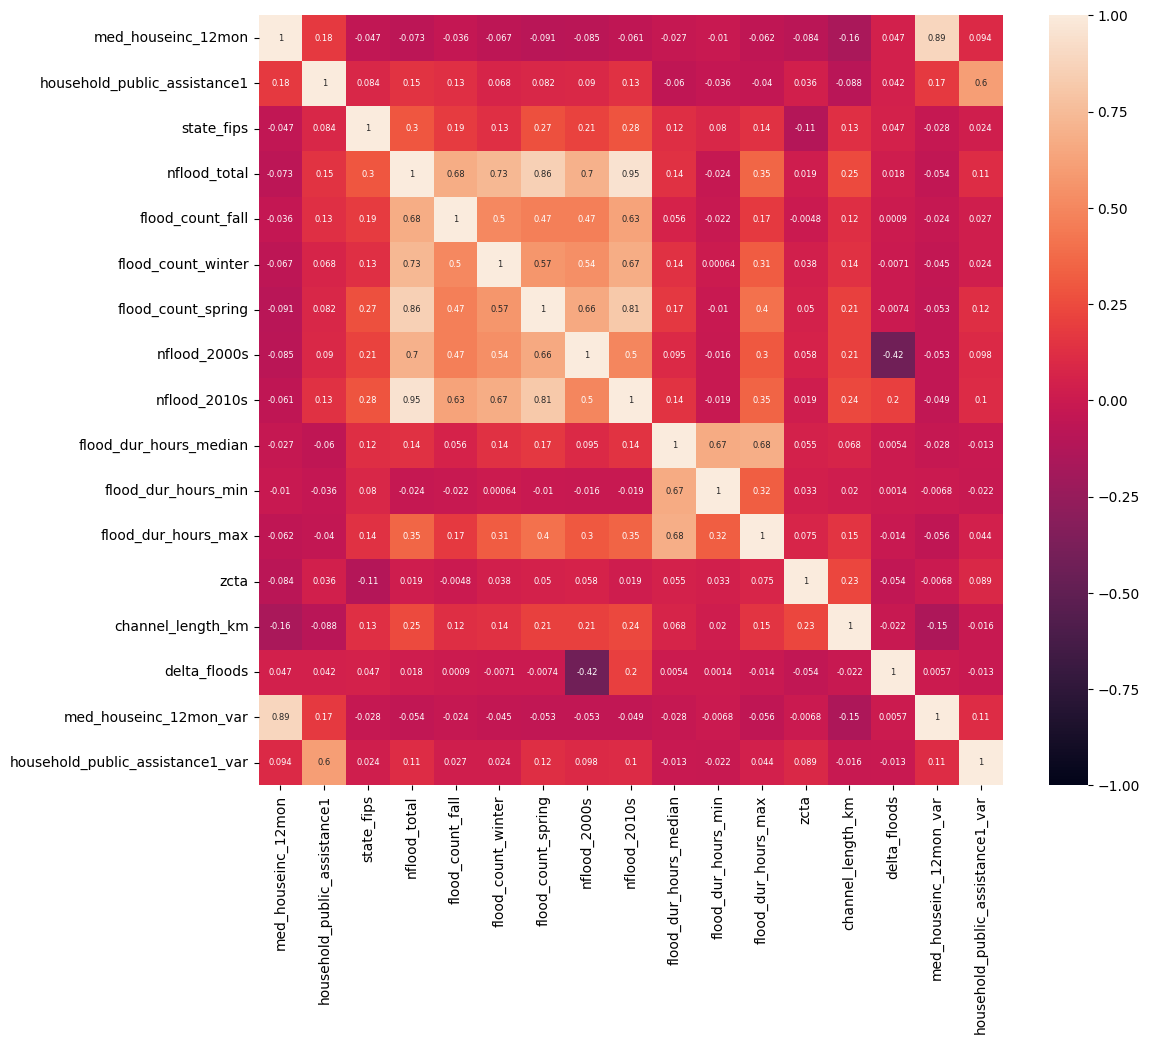

In [110]:
### show heatmap
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(data.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})
plt.show()


Pretty weak correlations... not sure if this will yield good results. 
Generally, variance metrics by state not as good correlation - remove for now


In [111]:
## drop variance columns
var_column_names = [x for x in data.columns if '_var' in x]
print(var_column_names)
data = data.drop(var_column_names, axis=1)


['med_houseinc_12mon_var', 'household_public_assistance1_var']


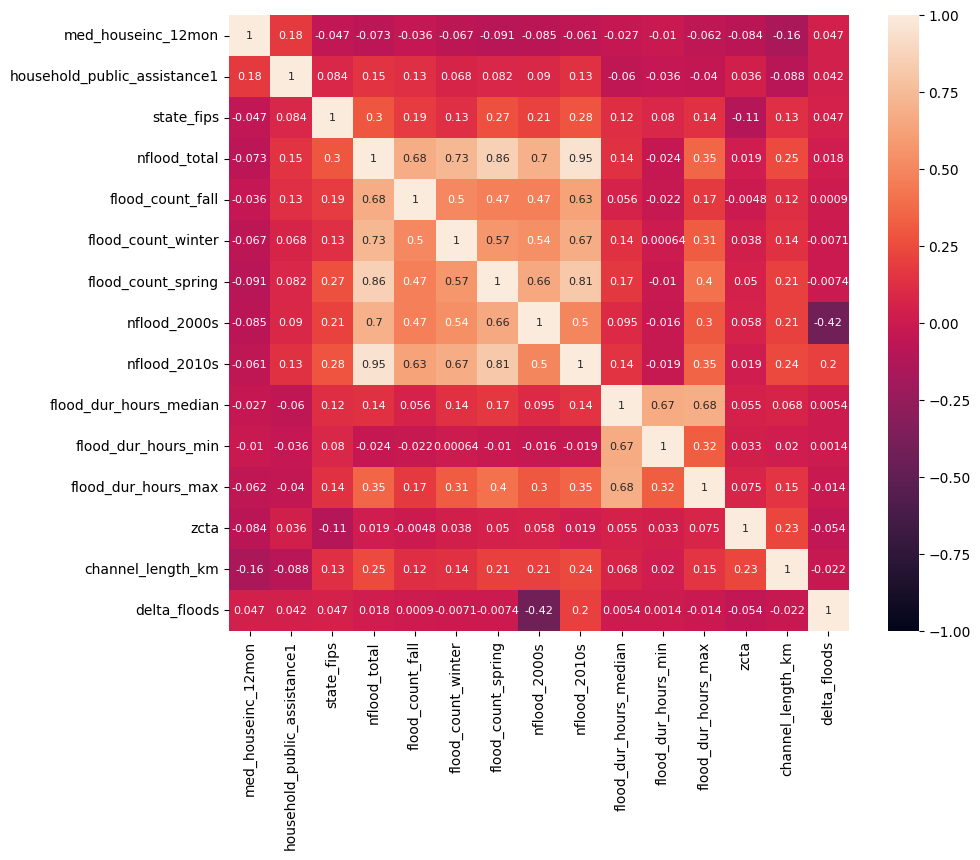

In [112]:
### show heatmap
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":8})
plt.show()


# Plot all the data

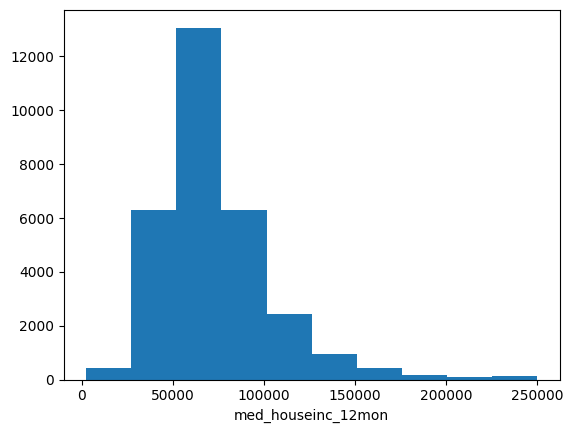

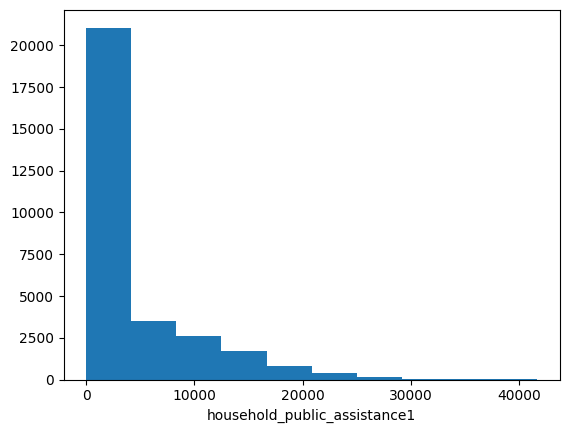

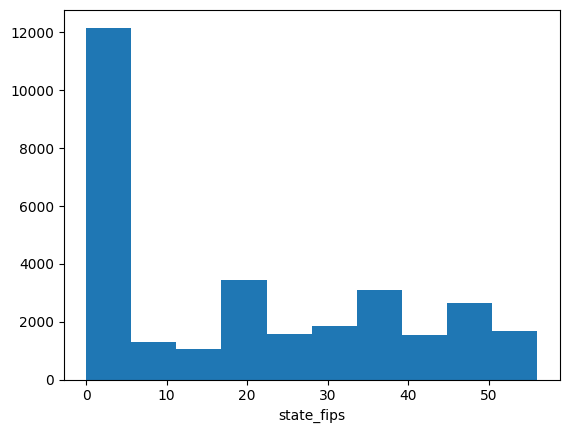

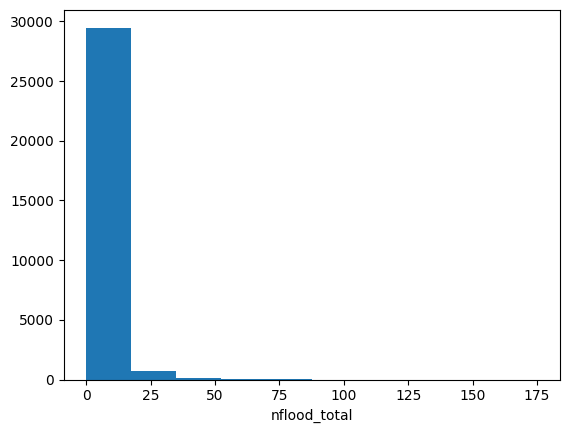

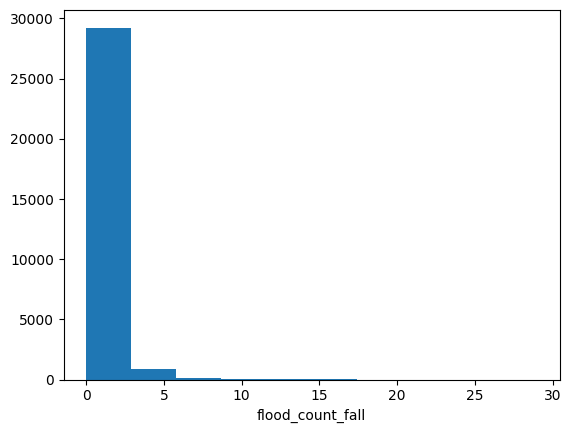

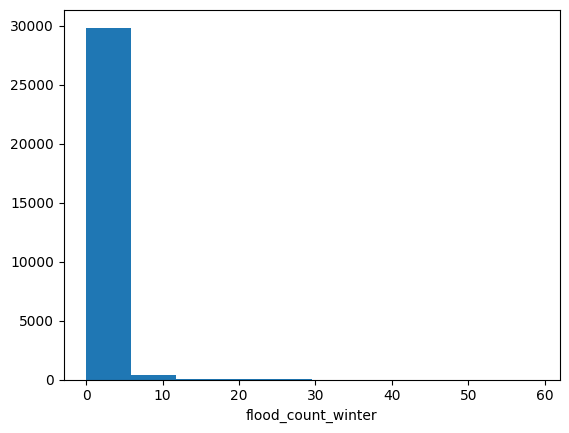

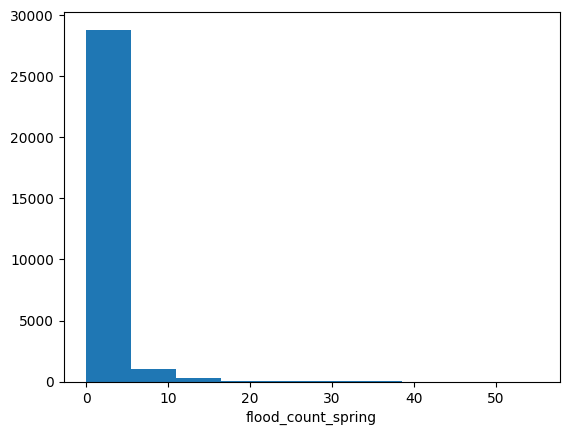

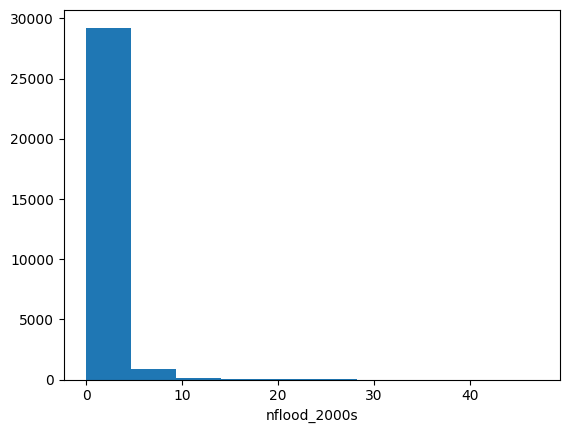

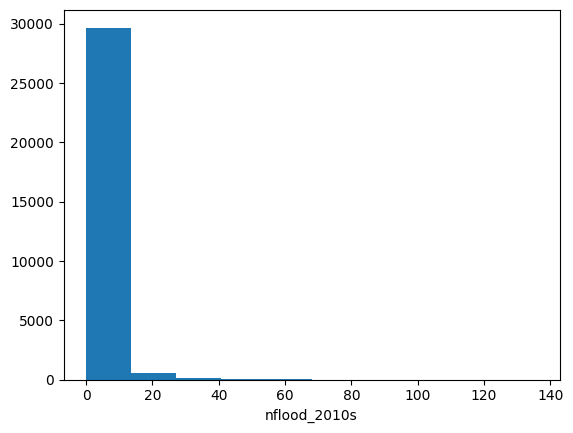

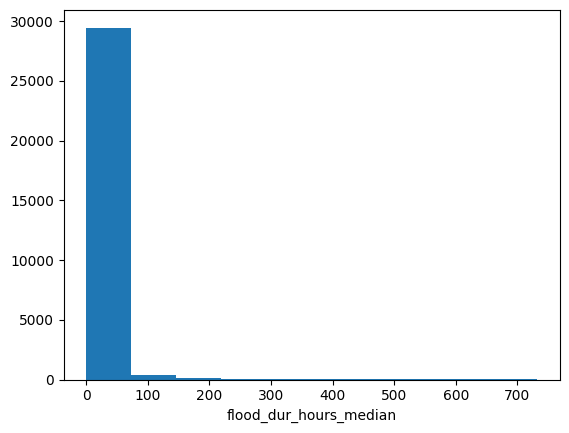

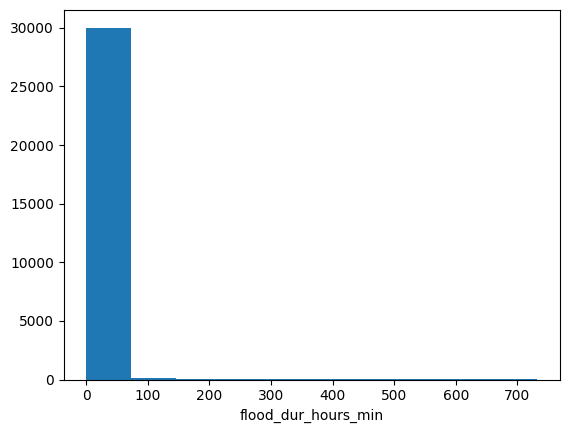

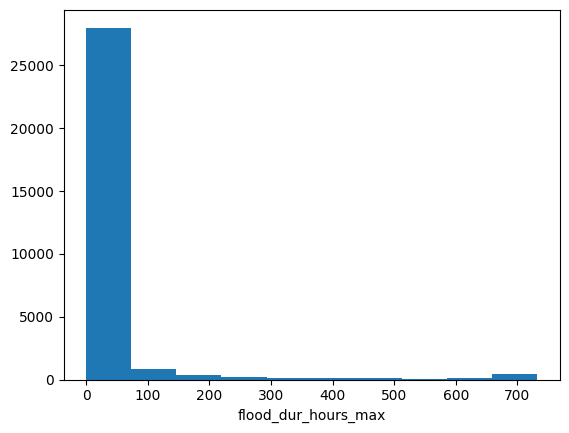

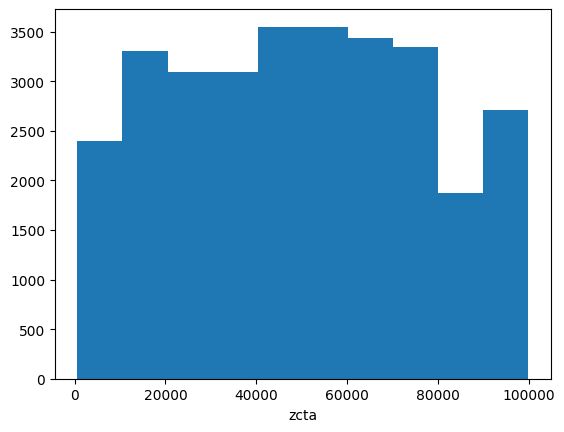

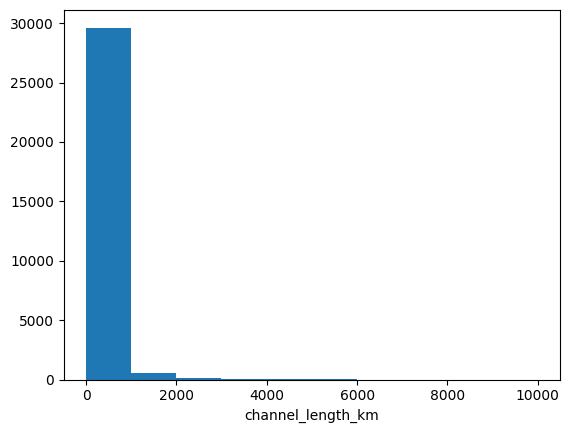

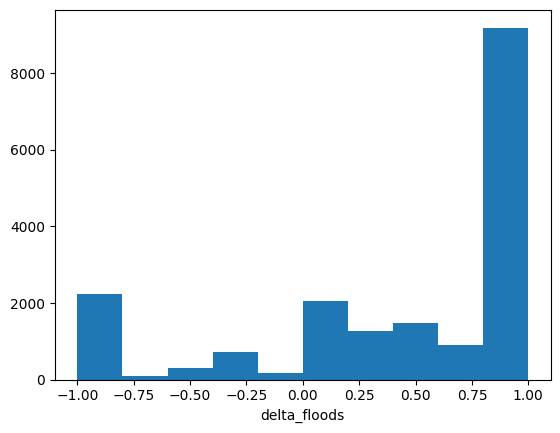

In [113]:
## plot each dataset

for n in data.columns:
    plt.hist(data[n])
    plt.xlabel(n)
    plt.show()


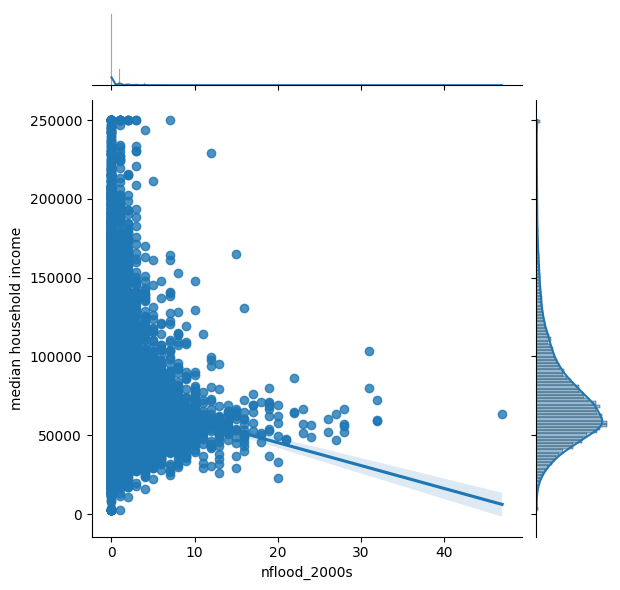

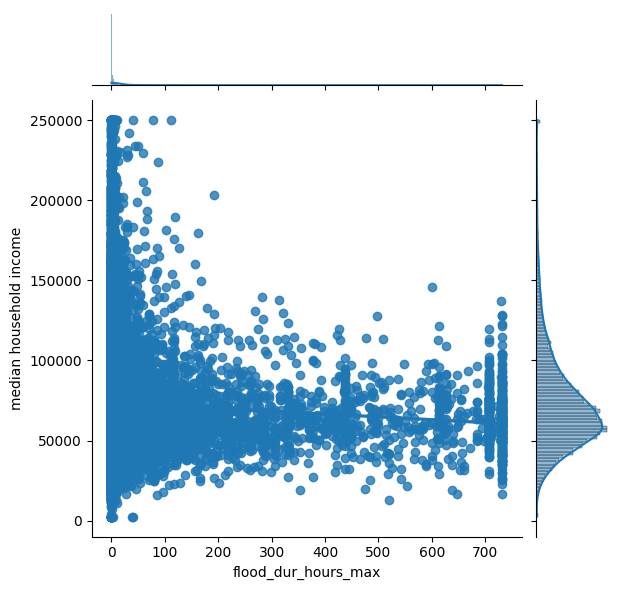

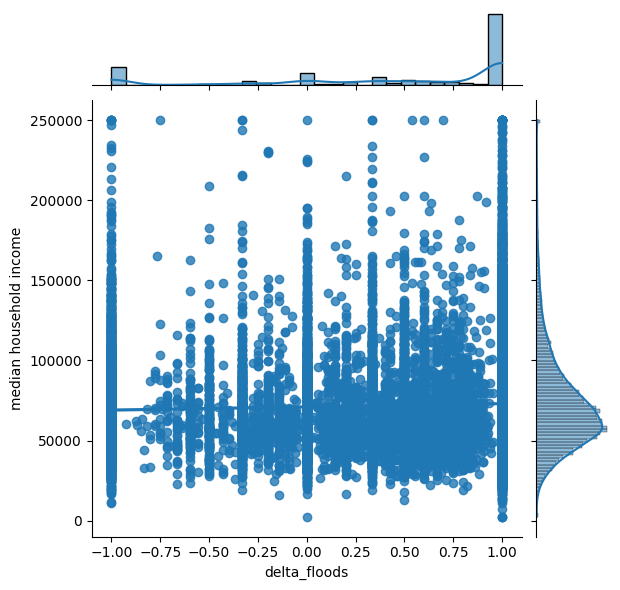

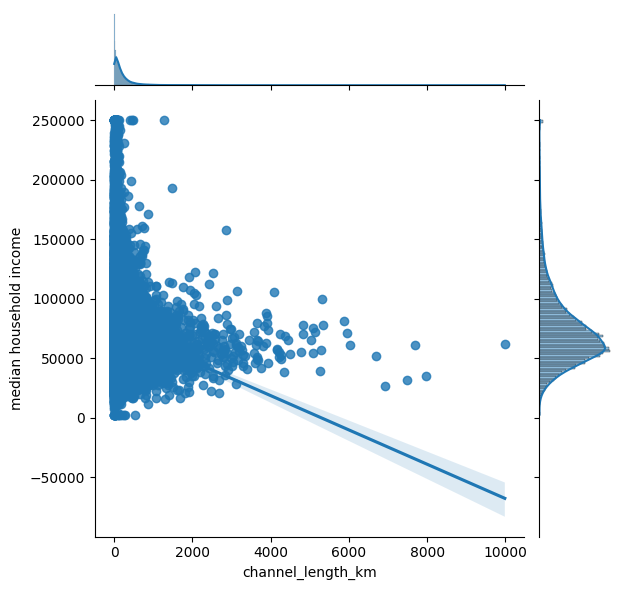

In [114]:
###plot 20th percentile income vs number of floods
pairplot_list = ['nflood_2000s', 'flood_dur_hours_max', 'delta_floods', 'channel_length_km']
for n in pairplot_list:
    sns.jointplot(data=data, x=n, y='med_houseinc_12mon', kind='reg')
    plt.ylabel('median household income')
    plt.xlabel(n)
    plt.show()



## Number of floods typically very small for most zip codes
Likley because of geography and not necessarily related to income at all... Perhaps think about finding a way to quantify distance from flooding source? 

some of the lowest-income zip codes have very few floods. How many have no floods at all? 


In [115]:
print('number of zctas with no floods: ', len(data.loc[data['nflood_total']==0, :])) 
data_morethan10 = data.loc[data['nflood_total']>10, :] 
print('number of zctas with more than 10 floods: ', len(data_morethan10)) 

data_morethan1 = data.loc[data['nflood_total']>1, :] 
print('number of zctas with more than 1 flood: ', len(data_morethan1)) 


number of zctas with no floods:  11013
number of zctas with more than 10 floods:  2170
number of zctas with more than 1 flood:  13836


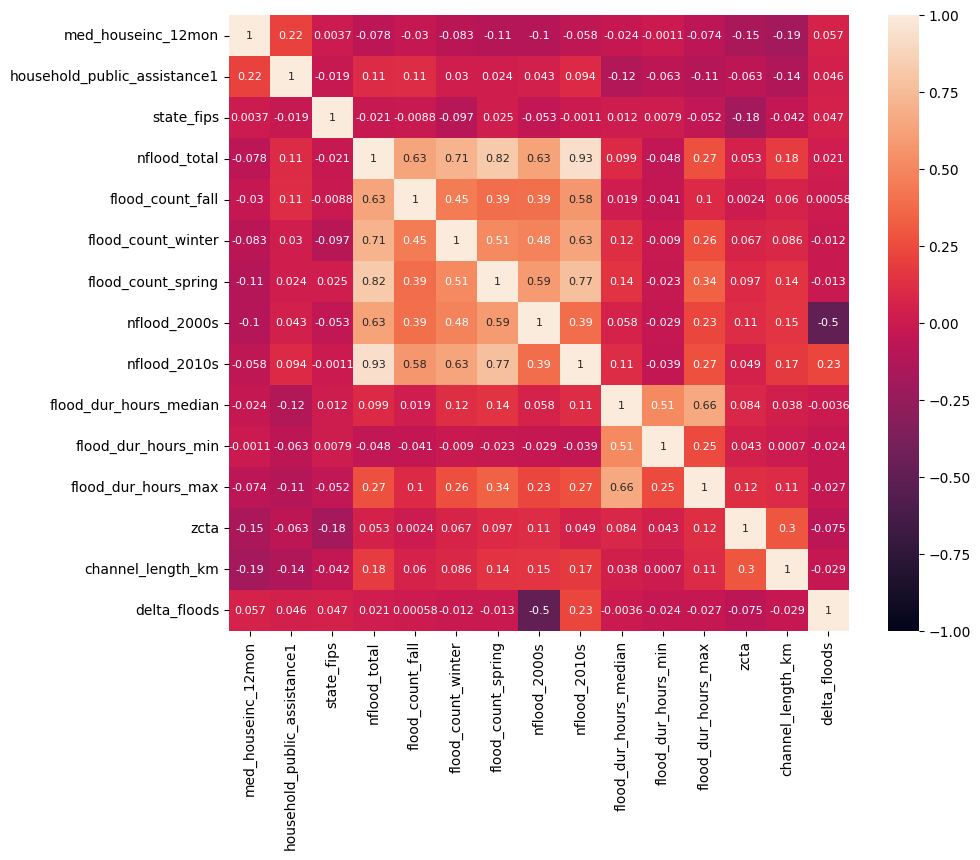

In [116]:
###repeat corr with this data
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data_morethan1.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":8})
plt.show()

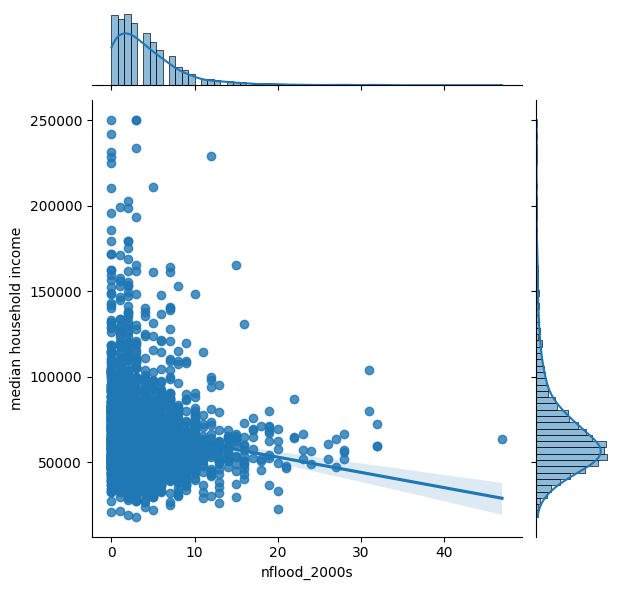

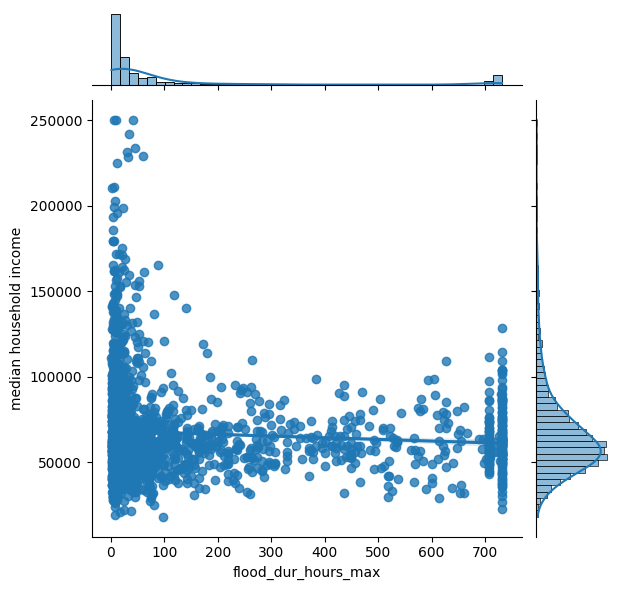

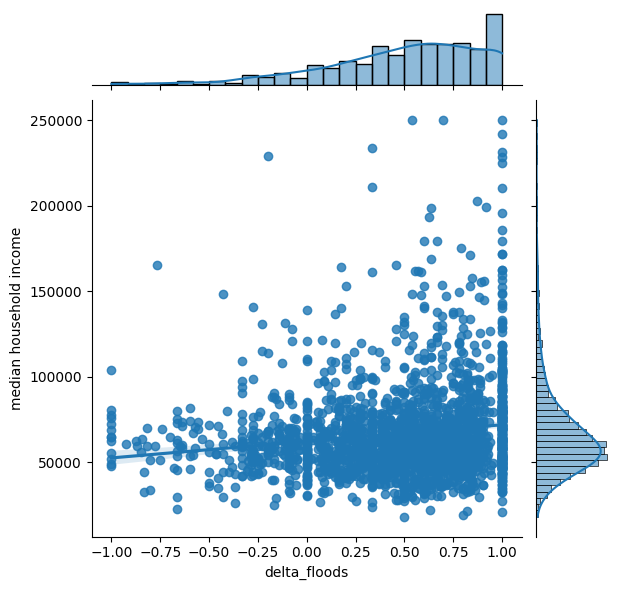

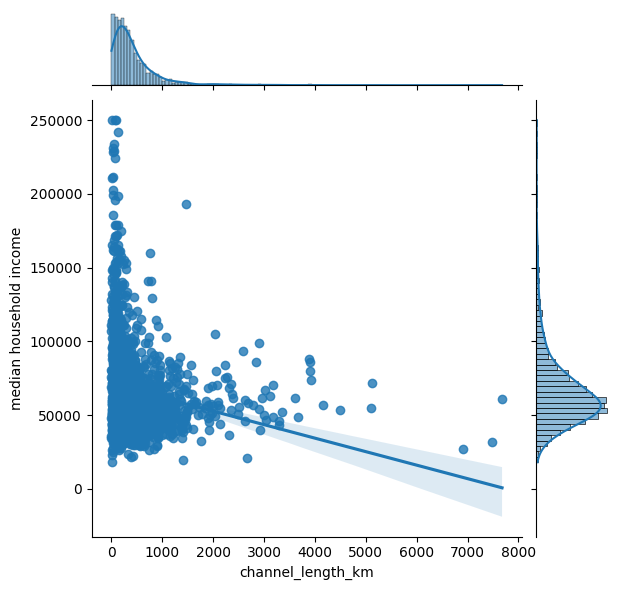

In [117]:
###plot median income vs number of floods
pairplot_list = ['nflood_2000s', 'flood_dur_hours_max', 'delta_floods', 'channel_length_km']
for n in pairplot_list:
    sns.jointplot(data=data_morethan10, x=n, y='med_houseinc_12mon', kind='reg')
    plt.ylabel('median household income')
    plt.xlabel(n)
    plt.show()

## remove floods less than 10
probably not helpful to remove floods less than 10. Data still not linear, and removes zips where num floods is low and income is high. 

In [118]:
data.to_csv('data/02_data.csv')

## State visualization

# Conclusions

1. No missing values, no outliers suggesting a data error
2. Data is not linear and so linear correlation is very low. Flood occurence possibly a Poisson distribution.
3. Best choice of target variable seems to be median income.
4. A good starting place for explanatory variables seem to be number of floods between 2000 and 2010, change in floods, and max flood duration, channel length, and seasonal flood counts
5. Because data is not linear, modeling will likely begin with ML algorithms. 
